# Q5 Assumed Density Filtering
### Q5.1 Pre-processing and variables

In [1]:
# Q5 Assumed density filtering
# import preprocessing function and Gibbs sampler function
from Preprocessing_serieA_function import preprocess_serieA_no_draws
from Gibbs_sampler_function import gibbs_sampling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# load data
data = pd.read_csv('SerieA_dataset.csv')

# preprocess data
data_preprocessed = preprocess_serieA_no_draws(data)
print(data_preprocessed.head())

# Create team dictionary test 1
unique_teams_1 = data_preprocessed['team1'].unique().tolist()
mean=[25 for i in range(len(unique_teams_1))]
variance=[64 for i in range(len(unique_teams_1))]

teams_dictionary = {i:[25,64] for i in unique_teams_1}

# Create team dictionary test 2 for shuffled data
shuffled_teams_dictionary = {i:[25,64] for i in unique_teams_1}

# shuffle data
shuffled_data = data_preprocessed.copy()
shuffled_data = shuffled_data.sample(frac=1).reset_index(drop=True)
print(shuffled_data.head())

# print(teams_dictionary)

game1 = data_preprocessed.iloc[0, :]
# print(game1[0])
# print(f'\nFirst game:\n {game1}')

      team1     team2  score_diff
0    Chievo  Juventus          -1
1     Lazio    Napoli          -1
2    Torino      Roma          -1
3  Sassuolo     Inter           1
5    Empoli  Cagliari           2
      team1      team2  score_diff
0   Udinese      Genoa           2
1  Cagliari  Frosinone           1
2     Parma     Empoli           1
3     Inter       Spal           2
4      Spal       Roma           1


# Q.6
### Q6.1 prediction function

In [2]:
# Prediction function (deterministic)
# if skills are equal, team 1 wins, might need to change this
def prediction(team1_mean, team2_mean):
    if team1_mean > team2_mean:
        return 1
    elif team1_mean < team2_mean:
        return -1
    elif team1_mean == team2_mean:
        return 1
    else:
        print('Error in prediction function')


### Q5.2 Assumed Density Filtering (ADF) function

In [3]:
# Assumed density filtering (ADF)
def ADF(teams_dictionary, dataframe):
    # print(dataframe.head())
    # print(teams_dictionary)

    # Assumed density filtering (ADF)
    n_iter = 1500
    t_var = 6
    burn_in = 250

    # One step ahead prediction
    predictions = []
    # Loop over all games

    for index, game1 in dataframe.iterrows():
        
        # Load means and variances from dictionary
      
        mean_team1 = float(teams_dictionary[game1[0]][0])
        mean_team2 = float(teams_dictionary[game1[1]][0])

        variance_team1 = float(teams_dictionary[game1[0]][1])
        variance_team2 = float(teams_dictionary[game1[1]][1])

        # One-Step-Ahead prediction
        y_pred = prediction(mean_team1, mean_team2)
        predictions.append(y_pred)
        
        # create mean column and covariance matrix
        s1_s2_mean_col = np.array([[mean_team1, mean_team2]]).reshape(-1,1)
        s_cov_matrix = np.array([[variance_team1, 0], [0, variance_team2]])

        score_difference = game1['score_diff']
        print(f'\nScore difference: {score_difference}')

        s1_samples, s2_samples = gibbs_sampling(n_iter, s1_s2_mean_col, s_cov_matrix, t_var, score_difference)

        # results
        s1_samples = s1_samples[burn_in:]
        s2_samples = s2_samples[burn_in:]

        s1_mean = np.mean(s1_samples)
        s2_mean = np.mean(s2_samples)
        s1_var = np.var(s1_samples)
        s2_var = np.var(s2_samples)

        # Update team dictionary means
        teams_dictionary[game1[0]][0] = s1_mean
        teams_dictionary[game1[1]][0] = s2_mean

        # update team dictionary variances
        teams_dictionary[game1[0]][1] = s1_var
        teams_dictionary[game1[1]][1] = s2_var

    return teams_dictionary, predictions

## Q5 & Q6: Run functions

In [4]:
# Run ADF on data
dic1, predictions1= ADF(teams_dictionary, data_preprocessed)

# # Run ADP on shuffled data
# dic_shuffled, predictions_shuffled = ADF(shuffled_teams_dictionary, shuffled_data)


Score difference: -1

Score difference: -1

Score difference: -1

Score difference: 1

Score difference: 2

Score difference: -1

Score difference: 4

Score difference: 2

Score difference: 1

Score difference: 1

Score difference: 1

Score difference: 1

Score difference: 5

Score difference: 1

Score difference: -3

Score difference: -1

Score difference: 1

Score difference: 1

Score difference: 2

Score difference: 3

Score difference: 1

Score difference: -1

Score difference: -1

Score difference: 1

Score difference: -5

Score difference: 1

Score difference: 1

Score difference: -1

Score difference: 2

Score difference: 2

Score difference: 2

Score difference: 3

Score difference: -1

Score difference: -2

Score difference: 3

Score difference: -2

Score difference: 2

Score difference: -2

Score difference: 1

Score difference: -1

Score difference: 4

Score difference: 3

Score difference: 2

Score difference: 2

Score difference: -2

Score difference: 2

Score difference:

# Results:
### Team ranking changes after shuffle
#### prediction rate of one-step-head = 0.64, better than random guessing(0.5)

In [7]:
# Create dataframe of means and variances an sort by means
from numpy import sign
teams_df = pd.DataFrame(dic1, index=['mean', 'variance']).T
teams_df = teams_df.sort_values(by=['mean'], ascending=False)
print('Teams after the season, no shuffle:')
print(teams_df)

# Calculate prediction rate
from sklearn.metrics import accuracy_score
y_true = sign(data_preprocessed['score_diff']).tolist()
prediction_rate = accuracy_score(y_true, predictions1)
print(f'\nPrediction rate of One-Step-Ahead prediction: {prediction_rate}')

# prediction rate of last 60 games
y_true_last_60 = y_true[-60:]
predictions_last_60 = predictions1[-60:]
prediction_rate_last_60 = accuracy_score(y_true_last_60, predictions_last_60)
print(f'\nPrediction rate of One-Step-Ahead prediction for last 60 games: {prediction_rate_last_60}')


# # create dataframe of shuffled means and variances
# teams_df_shuffled = pd.DataFrame(dic_shuffled, index=['mean', 'variance']).T
# teams_df_shuffled = teams_df_shuffled.sort_values(by=['mean'], ascending=False)
# print('\nTeams after the season, with shuffle:')
# print(teams_df_shuffled)

# # Calculate prediction rate
# y_true_shuffled = shuffled_data['y'].tolist()
# prediction_rate_shuffled = accuracy_score(y_true_shuffled, predictions_shuffled)
# print(f'\nPrediction rate of One-Step-Ahead prediction: {prediction_rate_shuffled}')

# # prediction rate of last 60 games
# y_true_last_60_shuffled = y_true_shuffled[-60:]
# predictions_last_60_shuffled = predictions_shuffled[-60:]
# prediction_rate_last_60_shuffled = accuracy_score(y_true_last_60_shuffled, predictions_last_60_shuffled)
# print(f'\nPrediction rate of One-Step-Ahead prediction for last 60 games: {prediction_rate_last_60_shuffled}')


Teams after the season, no shuffle:
                 mean  variance
Atalanta    27.275136  0.718556
Napoli      27.164191  1.165487
Milan       26.972329  0.910291
Torino      26.641279  0.908078
Inter       26.581591  0.766346
Juventus    26.451628  1.446443
Roma        26.111071  0.724550
Lazio       25.328455  0.659238
Bologna     24.765561  0.762839
Spal        24.625247  0.884958
Sampdoria   24.459325  0.569322
Udinese     24.452124  0.786453
Empoli      24.309915  0.746702
Genoa       23.962734  0.886657
Cagliari    23.713922  0.780156
Parma       23.658913  0.821880
Sassuolo    23.020001  1.074511
Fiorentina  22.526942  0.991764
Frosinone   22.038881  1.050310
Chievo      20.670994  2.162807

Prediction rate of One-Step-Ahead prediction: 0.6580882352941176

Prediction rate of One-Step-Ahead prediction for last 60 games: 0.7


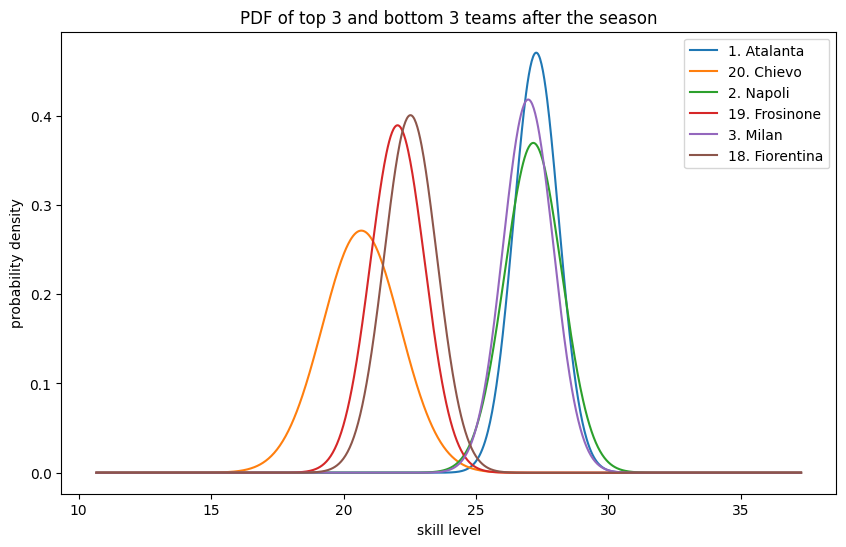

In [6]:
# Plot the pdf of the three top teams and the three bottom teams

plt.figure(figsize=(10, 6))
x = np.linspace(min(teams_df['mean'])-10, max(teams_df['mean'])+10, 1000)

for i in range(3):
    y_top = stats.norm.pdf(x, teams_df.iloc[i, 0], np.sqrt(teams_df.iloc[i, 1]))
    y_bottom = stats.norm.pdf(x, teams_df.iloc[-i-1, 0], np.sqrt(teams_df.iloc[-i-1, 1]))

    plt.plot(x, y_top, label=f'{i+1}. {teams_df.index[i]}')
    plt.plot(x, y_bottom, label=f'{len(teams_df)-i}. {teams_df.index[-i-1]}')

plt.title('PDF of top 3 and bottom 3 teams after the season')
plt.xlabel('skill level')
plt.ylabel('probability density')
plt.legend()
plt.show()

# Plot the pdf of the three top teams and the three bottom teams after shuffle

# plt.figure(figsize=(10, 6))
# x = np.linspace(10, 40, 1000)

# for i in range(3):
#     y_top = stats.norm.pdf(x, teams_df_shuffled.iloc[i, 0], np.sqrt(teams_df_shuffled.iloc[i, 1]))
#     y_bottom = stats.norm.pdf(x, teams_df_shuffled.iloc[-i-1, 0], np.sqrt(teams_df_shuffled.iloc[-i-1, 1]))

#     plt.plot(x, y_top, label=f'{i+1}. {teams_df_shuffled.index[i]}')
#     plt.plot(x, y_bottom, label=f'{len(teams_df_shuffled)-i}. {teams_df_shuffled.index[-i-1]}')

# plt.title('PDF of top 3 and bottom 3 teams after the season with shuffle')
# plt.xlabel('skill level')
# plt.ylabel('probability density')
# plt.legend()
# plt.show()
